# Introduction to Data Science
<img align="left" src = https://project.lsst.org/sites/default/files/Rubin-O-Logo_0.png width=250 style="padding: 10px"> 
<br>
Contact author(s): Becky Nevin, Brian Nord<br>
Last verified to run: 2025-05-06 <br>
LSST Science Pipelines version: Weekly 2025_09 <br>
Container size: small <br>
Targeted learning level: intermediate <br>

In [ ]:
%load_ext pycodestyle_magic
%flake8_on
import logging
logging.getLogger("flake8").setLevel(logging.FATAL)

**Description:** This notebook guides a PI through the process of using python's data science and machine learning libraries to explore data from complex ADQL queries with the TAP service. The goal is to build a predictive model to estimate missing $r-$band Kron Flux values when the other bands are available, and visualize the results and quantify the model performance.

**Skills:** Use of data science and machine learning tools such as scikit-learn, pandas, and seaborn.

**LSST Data Products:** Object, Forcedsource, and CcdVisit tables.

**Packages:** lsst.rsp, pandas, scikit-learn, seaborn

**Credits:** Developed by Becky Nevin in collaboration with Melissa Graham, Brian Nord, and the Rubin Community Science Team for DP0.2. Based on notebooks developed by Leanne Guy (TAP query) and Alex Drlica-Wagner and Melissa Graham (Butler query).
Please consider acknowledging them if this notebook is used for the preparation of journal articles, software releases, or other notebooks.

**Get Support:**
Find DP0-related documentation and resources at <a href="https://dp0.lsst.io">dp0.lsst.io</a>. Questions are welcome as new topics in the <a href="https://community.lsst.org/c/support/dp0">Support - Data Preview 0 Category</a> of the Rubin Community Forum. Rubin staff will respond to all questions posted there.

## 1. Introduction

This notebook provides an intermediate-level demonstration of how to use the Table Access Protocol (TAP) server and ADQL (Astronomy Data Query Language) to query and retrieve data from the DP0.2 catalogs.

TAP provides standardized access to catalog data for discovery, search, and retrieval.
Full <a href="http://www.ivoa.net/documents/TAP">documentation for TAP</a> is provided by the International Virtual Observatory Alliance (IVOA).
ADQL is similar to SQL (Structured Query Langage).
The <a href="http://www.ivoa.net/documents/latest/ADQL.html">documentation for ADQL</a> includes more information about syntax and keywords.
Note that not all ADQL functionality is supported yet in the DP0-era RSP.

**See the recommendations for TAP queries in DP0.2 tutorial 02a "Introduction to the TAP Service".**

The [documentation for Data Preview 0.2](https://dp0-2.lsst.io/) includes definitions
of the data products, descriptions of catalog contents, and ADQL recipes.

### 1.1. Package imports

Import general python packages, the Rubin TAP service utilities, and various scikit-learn utilities.

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas

from astropy import units as u
from astropy.coordinates import SkyCoord

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

from lsst.rsp import get_tap_service, retrieve_query

Set up seaborn to use a friendly palette.

In [105]:
sns.set_style('whitegrid')
palette = sns.color_palette("colorblind")
sns.set_palette(palette)

### 1.2. Define functions and parameters

Instantiate the TAP service.

In [87]:
service = get_tap_service("tap")
assert service is not None

Set the maximum number of rows to display from pandas.

In [88]:
pandas.set_option('display.max_rows', 6)

## 2. Query for Kron fluxes around extended (galaxy) objects.
I forget why I chose this specific statistic for the demo.

Kron radius: A radius that is calculated using the light profile of the object, typically as the first moment (i.e., a weighted average of radius with brightness) of the light distribution.

Kron flux: The total flux measured within a certain multiple (often 2.5×) of the Kron radius, typically capturing about 90–95% of the total light for extended sources like galaxies.

Define the coordinates and radius to use for the example queries in Sections 2 and 3.

In [89]:
center_ra = 62
center_dec = -37
radius = 0.1

str_center_coords = str(center_ra) + ", " + str(center_dec)
str_radius = str(radius)

Start with the same query as used in the beginner TAP tutorial notebook 02a.

In [90]:
query = "SELECT coord_ra, coord_dec, g_kronFlux, g_kronFlux_flag, "\
        "r_kronFlux, r_kronFlux_flag, i_kronFlux, i_kronFlux_flag "\
        "FROM dp02_dc2_catalogs.Object "\
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), "\
        "CIRCLE('ICRS', " + str_center_coords + ", " + str_radius + ")) = 1 "\
        "AND detect_isPrimary = 1 AND g_extendedness = 1"
print(query)

SELECT coord_ra, coord_dec, g_kronFlux, g_kronFlux_flag, r_kronFlux, r_kronFlux_flag, i_kronFlux, i_kronFlux_flag FROM dp02_dc2_catalogs.Object WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), CIRCLE('ICRS', 62, -37, 0.1)) = 1 AND detect_isPrimary = 1 AND g_extendedness = 1


Run the query job asynchronously.

In [91]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

Job phase is COMPLETED


## 3. Explore the data using a `pandas` DataFrame object.
From the `pandas` docs:
> A DataFrame is a two-dimensional, size-mutable, heterogeneous tabular data structure with labeled axes (rows and columns).

Return the results as a `pandas` dataframe, and then delete the query to save space.

In [92]:
results = job.fetch_result().to_table().to_pandas()
job.delete()
del query

Display `results`.

In [93]:
results

,coord_ra,coord_dec,g_kronFlux,g_kronFlux_flag,r_kronFlux,r_kronFlux_flag,i_kronFlux,i_kronFlux_flag
0,62.018897,-37.095671,71.568352,True,91.185588,True,624.454022,True
1,62.020999,-37.093227,174.729861,False,110.922305,False,52.040203,True
2,62.000430,-37.093196,131.680920,False,137.655812,False,136.174616,True
...,...,...,...,...,...,...,...,...
11561,61.950427,-36.946586,51.054369,True,175.646973,False,123.073904,True
11562,61.976752,-36.904225,199.039503,False,187.972452,False,115.825734,False
11563,61.932319,-36.941077,266.123377,False,218.853195,False,481.650950,True


In [94]:
type(results)

pandas.core.frame.DataFrame

There's a lot of options for investigating DataFrame objects. Some options are inspection- and summary-oriented, such as the `.head()`, `.tail()`, and `.describe()` attributes.

Check these out now. `.head()` and `.tail()` show the first and last five rows, respectively, but can be modified to print out a different number of rows. `.describe()` provides statistics of the distribution of values in each column, including the mean and standard deviation.

In [95]:
print(results.head())
print(results.tail(10))
print(results.describe())

    coord_ra  coord_dec  g_kronFlux  g_kronFlux_flag  r_kronFlux  \
0  62.018897 -37.095671   71.568352             True   91.185588   
1  62.020999 -37.093227  174.729861            False  110.922305   
2  62.000430 -37.093196  131.680920            False  137.655812   
3  62.015568 -37.092868  372.665560            False  171.582869   
4  62.002969 -37.092762  247.219720            False  153.138653   

   r_kronFlux_flag  i_kronFlux  i_kronFlux_flag  
0             True  624.454022             True  
1            False   52.040203             True  
2            False  136.174616             True  
3            False  211.338418             True  
4             True  184.829166             True  
        coord_ra  coord_dec  g_kronFlux  g_kronFlux_flag  r_kronFlux  \
11554  61.913511 -36.960012  158.939682            False         NaN   
11555  61.986424 -36.950292  125.535210            False   71.749436   
11556  61.942562 -36.951137  108.966860            False  135.301872   
...

## 4. Visualize using `seaborn`
Use the boxplot tool from `seaborn` to visualize the distribution of the values in each column of the DataFrame.

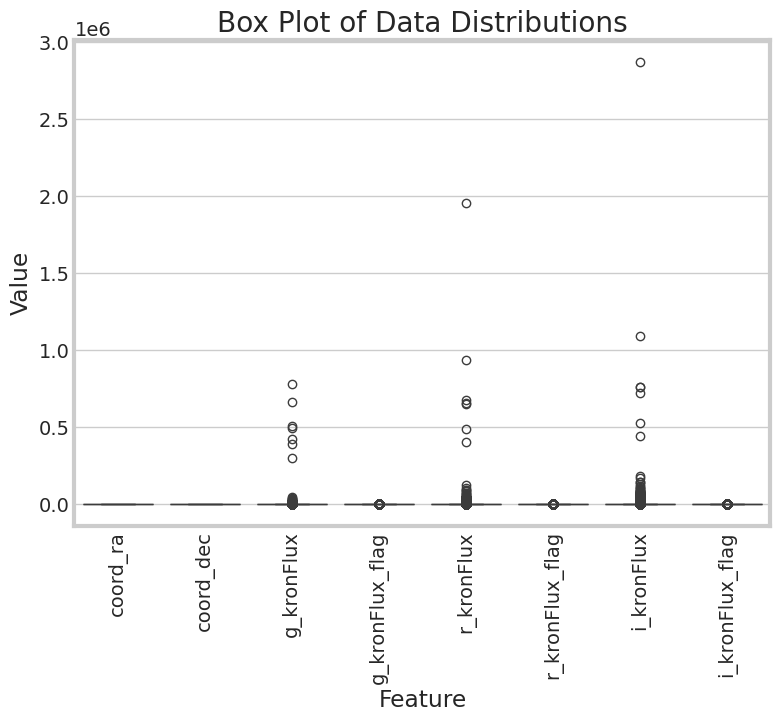

In [96]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=results)
plt.title('Box Plot of Data Distributions')
plt.xlabel('Feature')
plt.ylabel('Value')
plt.xticks(rotation=90)
plt.show()

The outliers are dominant in the visualization. Hide these and also only plot the kron Flux values.

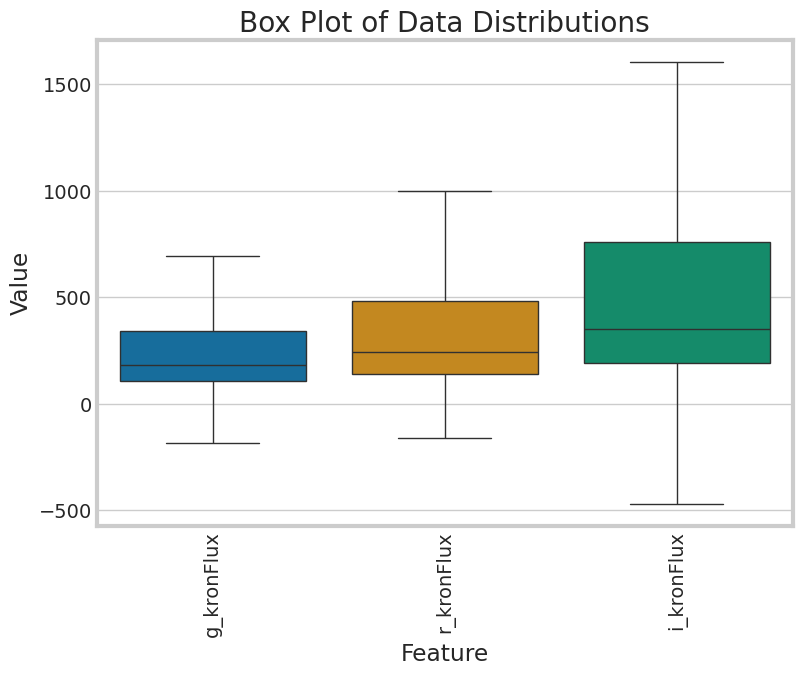

In [106]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=results[['g_kronFlux','r_kronFlux','i_kronFlux']], showfliers=False)
plt.title('Box Plot of Data Distributions')
plt.xlabel('Feature')
plt.ylabel('Value')
plt.xticks(rotation=90)
plt.show()

Boxplots show a box and whiskers.
- The "box" is the interquartile range (IQR), which is the 25th percentile of the distribution of a value to the 75th percentile.
- The horizontal line inside the box is the median of the distribution.
- The whisker extends from the IQR to 1.5*IQR away from the edge of the box.
- Points outside the whisker are considered outliers (hidden here).


Use `seaborn`'s violinplot tool to visualize the distribution for these same Kron flux values.

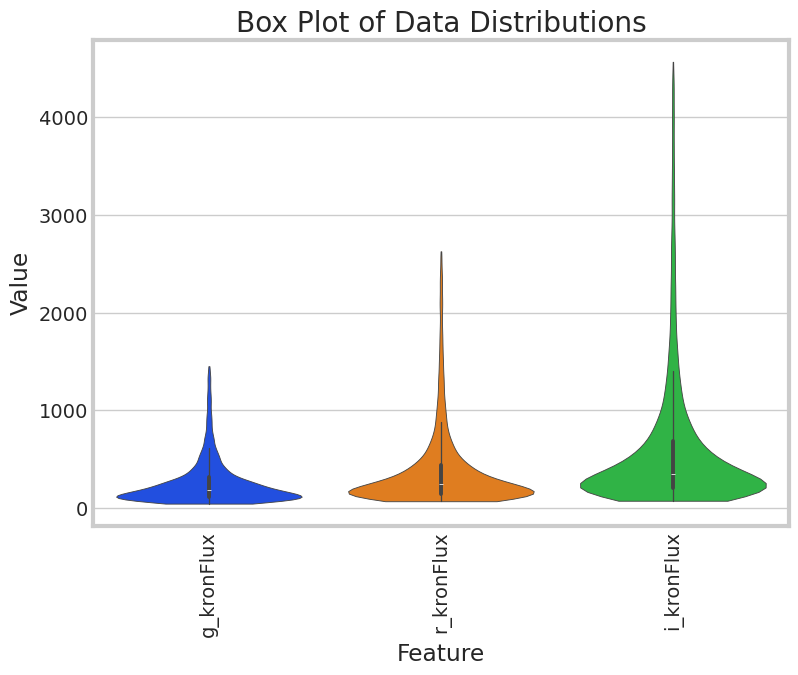

In [104]:
plt.figure(figsize=(8, 6))
filtered_results = results[['g_kronFlux', 'r_kronFlux', 'i_kronFlux']].apply(lambda x: x[(x > x.quantile(0.05)) & (x < x.quantile(0.95))])
sns.violinplot(data=filtered_results,
              cut=0)
plt.title('Box Plot of Data Distributions')
plt.xlabel('Feature')
plt.ylabel('Value')
plt.xticks(rotation=90)
plt.show()

A violinplot gives a lot of the same information as a boxplot, in fact, there are little boxplots within the violinplot; the horizontal white line is the median, the thicker grey box is the IQR and the thin line shows the 1.5*IQR span. A violinplot also uses a kernel density extimator to visualize the distribution of each feature. These plots reveal that most of the data are clustered around relatively low values for all of the Kron fluxes.

## 5. Investigate the fluxes and associated flags

Use `pandas` to investigate if there are any flags on the `kronFlux` measurement. The `.value_counts()` method will show the number of True and False columns, where True are rows for which the `g_kronFlux` measurement was flagged for a variety of reasons. There are many other columns that investigate specific reasons why this measurement is untrustworthy; the `g_kronFlux_flag` is a way to combine all of the individual flags.

In [51]:
results['g_kronFlux_flag'].value_counts()

g_kronFlux_flag
False    10728
True       836
Name: count, dtype: int64

Okay what about the `r_kronFlux` measurement?

In [15]:
results['r_kronFlux_flag'].value_counts()

r_kronFlux_flag
False    10723
True       841
Name: count, dtype: int64

Perform an intersection to see if the flagged entries overlap between these two photometric bands.

In [16]:
r_values = set(results['r_kronFlux_flag'].unique())
g_values = set(results['g_kronFlux_flag'].unique())

overlap = r_values & g_values

overlap_true_rows = results[
    (results['r_kronFlux_flag'].isin(overlap)) & 
    (results['g_kronFlux_flag'].isin(overlap)) & 
    (results['r_kronFlux_flag'] == True) & 
    (results['g_kronFlux_flag'] == True)
]

print(overlap_true_rows)

        coord_ra  coord_dec  g_kronFlux  g_kronFlux_flag  r_kronFlux  \
1749   61.916451 -37.018987  232.455339             True  380.415747   
1758   61.910063 -37.017256  115.486047             True  105.318235   
1774   61.950787 -37.015252  132.207788             True  193.917364   
...          ...        ...         ...              ...         ...   
11466  61.956032 -37.074942   59.901381             True  315.077832   
11471  61.942023 -37.073313  145.759753             True  120.304211   
11494  61.924542 -37.071842  248.013148             True  273.729756   

       r_kronFlux_flag  i_kronFlux  i_kronFlux_flag  
1749              True  562.754481            False  
1758              True  218.924537             True  
1774              True  522.751057            False  
...                ...         ...              ...  
11466             True         NaN             True  
11471             True  243.456290             True  
11494             True  257.108970           

There are six overlapping rows, meaning that in six cases, both photometric bands are flagged. Since the task at hand is a prediction one between three bands ($g$, $r$, and $i$) the bigger concern is the cases where any of these three Kron fluxes are flagged. Exclude rows where this is the case and build a clean DataFrame.

In [54]:
clean = results[
    (results['r_kronFlux_flag'] == False) & 
    (results['g_kronFlux_flag'] == False) &
    (results['i_kronFlux_flag'] == False)
]

Visualize the relationship between $g$ and $r$ in this clean DataFrame.

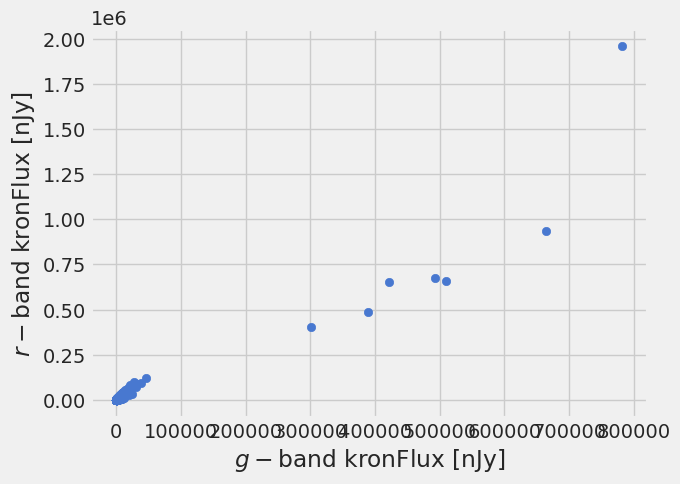

In [55]:
plt.scatter(clean['g_kronFlux'], clean['r_kronFlux'])
plt.xlabel(r'$g-$band kronFlux [nJy]')
plt.ylabel(r'$r-$band kronFlux [nJy]');

Zoom in.

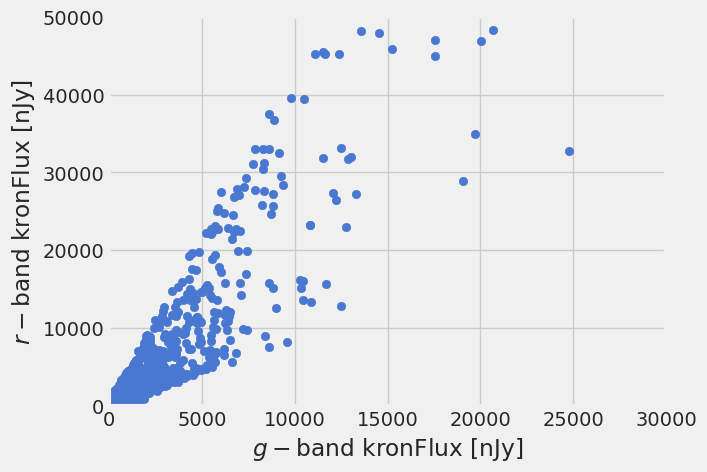

In [56]:
plt.scatter(clean['g_kronFlux'], clean['r_kronFlux'])
plt.xlabel(r'$g-$band kronFlux [nJy]')
plt.ylabel(r'$r-$band kronFlux [nJy]')
plt.xlim([0,30000])
plt.ylim([0,0.5e5]);

The relationship between $g-$ and $r-$band Kron fluxes looks roughly linear, so we should be able to do some predictive work here.

## 6. Prepare the training and test sets
The goal is to predict the $r-$band Kron flux using the $g-$band Kron flux. The first step is to define the training and validation data.

In [58]:
X_train, X_test, y_train, y_test = train_test_split(
    clean['g_kronFlux'].to_frame(), clean['r_kronFlux'].to_frame(), test_size=0.2, random_state=42)

The `.to_frame()` argument is required to input the X data as a 2D shape, as expected by `scikit-learn`.

It's practice to use a standard scaler when training machine learning models. Transform the training and test data.

In [66]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

The values of the training and test set should be scaled between values of 0 and 1 by default. Check this using a `seaborn` histogram.

/tmp/ipykernel_22441/4138889604.py:1: RuntimeWarning: invalid value encountered in log
  plt.hist(np.log(X_train.flatten()));


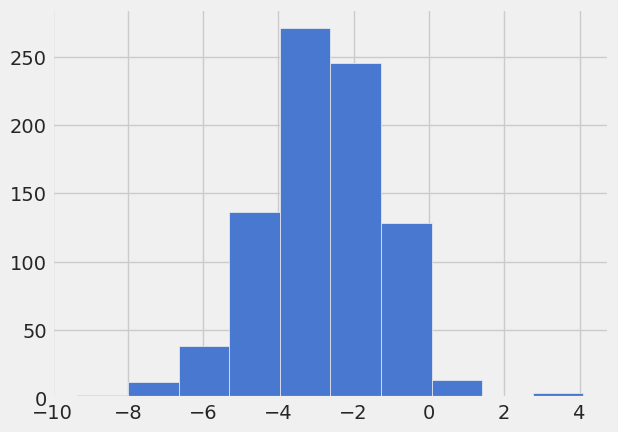

In [73]:
plt.hist(np.log(X_train.flatten()));

## 7. Model (using `scikit-learn`)

## 7.1 Start with a linear regression

In [23]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [24]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

MSE: 81831676.75317723


Plot how the predicted values compare to the true values.

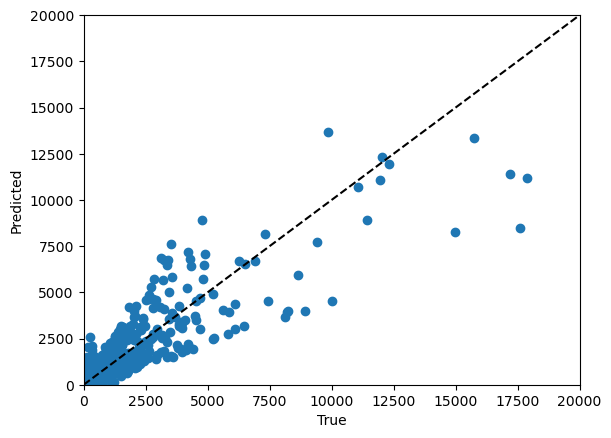

In [25]:
plt.clf()
plt.scatter(y_test, y_pred)
plt.plot([0,1e6],[0,1e6], color='black', ls='--')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.xlim([0,2e4])
plt.ylim([0,2e4]);

## 7.2 Improve the model with more features
Let's see if this will improve with more predictive values, this time including the i band information.

MSE: 409962.71379404626


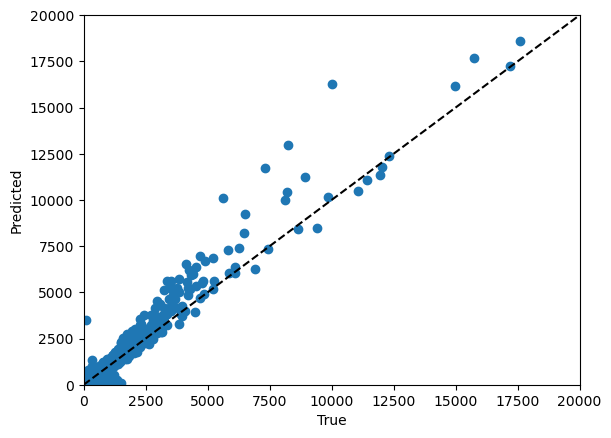

In [26]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    clean[['g_kronFlux', 'i_kronFlux']],  # Use these two features
    clean['r_kronFlux'],                 # Target variable
    test_size=0.2,
    random_state=42
)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

# Scatter plot: True vs Predicted
plt.clf()
plt.scatter(y_test, y_pred)
plt.plot([0, 1e6], [0, 1e6], color='black', ls='--')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.xlim([0, 2e4])
plt.ylim([0, 2e4])
plt.show()

Test for the reader: try to improve this further by including more features.

## 7.3 Random forest regressor
These are great

MSE: 33565886.06951628


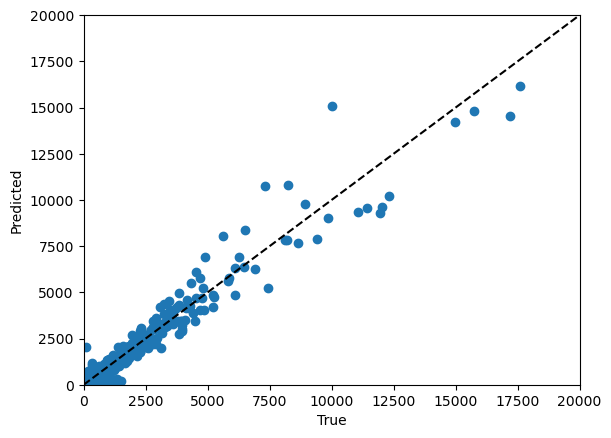

In [27]:
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

# Scatter plot: True vs Predicted
plt.clf()
plt.scatter(y_test, y_pred)
plt.plot([0, 1e6], [0, 1e6], color='black', ls='--')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.xlim([0, 2e4])
plt.ylim([0, 2e4])
plt.show()

## 8. Hyperparameter tuning
With any `scikit-learn` model, it's possible to tune the hyperparameters to achieve better performance.

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators': [1, 10, 50, 100, 200, 1000, 10000]} # default 100 for n_estimators

# Create GridSearchCV object
grid = GridSearchCV(model, param_grid, cv=5)

grid.fit(X_train, y_train)

# Get the best parameters
print(grid.best_params_)

### 8.2 Now retrieve the best fit model

Best Model: RandomForestRegressor(n_estimators=1000)


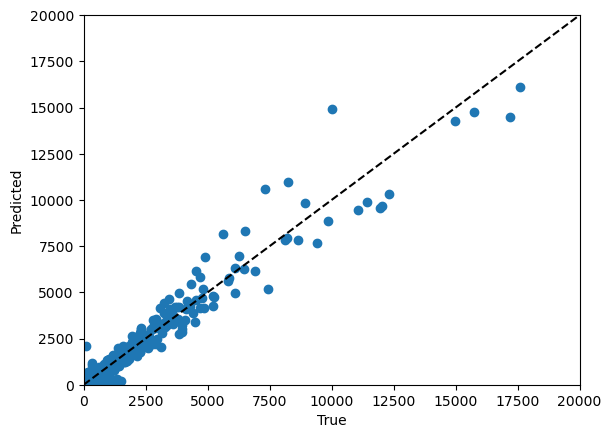

MSE: 19817809.291009396


In [43]:
best_model = grid.best_estimator_
print("Best Model:", best_model)
y_pred = best_model.predict(X_test)
plt.clf()
plt.scatter(y_test, y_pred)
plt.plot([0, 1e6], [0, 1e6], color='black', ls='--')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.xlim([0, 2e4])
plt.ylim([0, 2e4])
plt.show()

mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)

## 9. Other available `scikit-learn` choices
The below two cells explore available options from `scikit-learn` for regression metrics and regression models, respectively. The metric cell is truncated with a `break` statement to only print details of the first metric. The model cell demonstrates printing the class information for the `RandomForestRegressor` class.

In [19]:
import sklearn.metrics as metrics
import inspect
regression_metrics = [
    name for name, obj in inspect.getmembers(metrics)
    if inspect.isfunction(obj)
    and ('regression' in (obj.__doc__ or '').lower() or 'error' in (obj.__doc__ or '').lower())
    and 'classification' not in (obj.__doc__ or '').lower()
]
print(regression_metrics)


# Print the filtered metrics and their documentation
for metric in regression_metrics:
    metric_func = getattr(metrics, metric)
    if metric == "mean_tweedie_deviance":
        print(f"--- {metric} ---")
        help(metric_func)
        print("="*80)

['brier_score_loss', 'check_scoring', 'coverage_error', 'd2_absolute_error_score', 'd2_pinball_score', 'd2_tweedie_score', 'explained_variance_score', 'label_ranking_loss', 'log_loss', 'max_error', 'mean_absolute_error', 'mean_absolute_percentage_error', 'mean_gamma_deviance', 'mean_pinball_loss', 'mean_poisson_deviance', 'mean_squared_error', 'mean_squared_log_error', 'mean_tweedie_deviance', 'median_absolute_error', 'pairwise_distances', 'r2_score', 'root_mean_squared_error', 'root_mean_squared_log_error']
--- mean_tweedie_deviance ---
Help on function mean_tweedie_deviance in module sklearn.metrics._regression:

mean_tweedie_deviance(y_true, y_pred, *, sample_weight=None, power=0)
    Mean Tweedie deviance regression loss.
    
    Read more in the :ref:`User Guide <mean_tweedie_deviance>`.
    
    Parameters
    ----------
    y_true : array-like of shape (n_samples,)
        Ground truth (correct) target values.
    
    y_pred : array-like of shape (n_samples,)
        Estimated

In [10]:
from sklearn.utils import all_estimators

# Get all regression models
regressors = all_estimators(type_filter='regressor')

# Print the names of all available regression models
for name, estimator in regressors:
    print(name)

for name, estimator in regressors:
    if name == "RandomForestRegressor":
        print(help(estimator))

ARDRegression
AdaBoostRegressor
BaggingRegressor
BayesianRidge
CCA
DecisionTreeRegressor
DummyRegressor
ElasticNet
ElasticNetCV
ExtraTreeRegressor
ExtraTreesRegressor
GammaRegressor
GaussianProcessRegressor
GradientBoostingRegressor
HistGradientBoostingRegressor
HuberRegressor
IsotonicRegression
KNeighborsRegressor
KernelRidge
Lars
LarsCV
Lasso
LassoCV
LassoLars
LassoLarsCV
LassoLarsIC
LinearRegression
LinearSVR
MLPRegressor
MultiOutputRegressor
MultiTaskElasticNet
MultiTaskElasticNetCV
MultiTaskLasso
MultiTaskLassoCV
NuSVR
OrthogonalMatchingPursuit
OrthogonalMatchingPursuitCV
PLSCanonical
PLSRegression
PassiveAggressiveRegressor
PoissonRegressor
QuantileRegressor
RANSACRegressor
RadiusNeighborsRegressor
RandomForestRegressor
Help on class RandomForestRegressor in module sklearn.ensemble._forest:

class RandomForestRegressor(ForestRegressor)
 |  RandomForestRegressor(n_estimators=100, *, criterion='squared_error', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_frac